In [1]:
# from pydap.client import open_url
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset

#from net_cdf_functions import *
from degree_day_equations import single_sine_horizontal_cutoff
#from visualization_functions import *
import numpy as np
from processing_functions import *
import pandas as pd
import dask
import dask.array as da
import warnings

# %matplotlib inline
# import dask
from dask.distributed import Client

# check if port is already in use

# client = Client(n_workers=3, threads_per_worker=1, memory_limit="2GB")
# client

#data_path = "/media/thom/Q/data/"
data_path = 'data/test/'


# fetch and save data 2000-2020
'''
for year in range(2000, 2020):
    fetch_and_save_data(year, 1, 10, data_path)
'''

##########################################################################################
# check if client is already running

client = Client(n_workers=2, threads_per_worker=2, memory_limit="2GB")
client

prism_year_stack = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    combine="by_coords",
    drop_variables=["ppt", "tmean"],
)
# prism_year_stack = prism_year_stack.chunk({"latitude": 100, "longitude": 100})

la_single, la_single_mask = subset_dataset_by_coords(
    prism_year_stack, 34.05, -118.25, window_size=None
)
la_window, la_window_mask = subset_dataset_by_coords(
    prism_year_stack, 34.05, -118.25, 0.25
)
ks_window, ks_window_mask = subset_dataset_by_coords(prism_year_stack, 39.5, -96.5, 0.5)
prism_year_stack.close()
##########################################################################################


# la_single_dd = da_calculate_degree_days(12, 36, la_single)
la_window_dd = da_calculate_degree_days(12, 36, la_window)
la_window.close()

# compute the threshold reached days for the window
la_start_dates = create_start_date_array(la_window_dd, "2000-01-02")
la_threshold_reached_days_1 = compute_dd_threshold_reached_dates(
    la_window_dd, la_start_dates, 10
)
la_threshold_reached_days_2 = compute_dd_threshold_reached_dates(
    la_window_dd, la_threshold_reached_days_1, 10
)

/home/thom/Desktop/CIPM/FruitFlyPheno/processing_functions.py:80: UserWarning: Development error: NaN values in degree days
  warnings.warn("Development error: NaN values in degree days")


In [1]:
# from pydap.client import open_url
import os
from pydap.client import open_url
import xarray as xr
import datetime
from datetime import timedelta, date
import netCDF4 as nc
from netCDF4 import Dataset

# from net_cdf_functions import *
from degree_day_equations import single_sine_horizontal_cutoff

# from visualization_functions import *
import numpy as np
from processing_functions import *
import pandas as pd
import dask
import dask.array as da
import warnings
import glob
# %matplotlib inline
# import dask
from dask.distributed import Client
data_path = "data/test/"

client = Client(n_workers=3, threads_per_worker=1, memory_limit="2GB")
# client

In [4]:
import glob

In [5]:
data_path = "data/test/"
def subset_dataset_by_coords(dataset, lat, lon, window_size=None):
    if window_size is not None:
        # Define the window boundaries
        lat_min = lat - window_size
        lat_max = lat + window_size
        lon_min = lon - window_size
        lon_max = lon + window_size

        # Create boolean masks for the coordinate ranges
        mask_lat = (dataset.latitude >= lat_min) & (dataset.latitude <= lat_max)
        mask_lon = (dataset.longitude >= lon_min) & (dataset.longitude <= lon_max)

        # Apply the mask using .where() and drop the data points outside the window
        subset = dataset.where(mask_lat & mask_lon, drop=True)
        nan_mask = subset.isnull().any(dim="t")
        # combine tmin and tmax into one mask
        nan_mask = nan_mask.tmin | nan_mask.tmax

        # subset = subset.fillna(-9999)
        # Check if the subset contains only NaN values

        # Create a 2D mask for NaN values in the subset
        # .any(dim="t")
        return subset, nan_mask
    else:
        subset = dataset.sel(latitude=lat, longitude=lon, method="nearest")
        # Check if the subset contains only NaN values
        # print any nan values

        # Create a mask for NaN values in the subset
        nan_mask = subset.isnull().any(dim="t")
        nan_mask = nan_mask.tmin | nan_mask.tmax
        return subset, nan_mask


import time
# fetch and save data 2000-2020
"""
for year in range(2000, 2020):
    fetch_and_save_data(year, 1, 10, data_path)
"""

##########################################################################################
# check if client is already running

client = Client(n_workers=2, threads_per_worker=2, memory_limit="2GB")
client
# start timer
start_1 = datetime.datetime.now()

prism_year_stack_base = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    combine="by_coords",
    drop_variables=["ppt", "tmean"],
)
la_window_base, la_window_mask_base = subset_dataset_by_coords(
    prism_year_stack_base, 34.05, -118.25, 0.25
)
# stop timer
end_1 = datetime.datetime.now()
print(f"Time elapsed: {end_1 - start_1}")

# start timer
start_2 = datetime.datetime.now()

prism_year_stack_modified = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    #chunks={"latitude": 100, "longitude": 100},
    combine="nested",
    drop_variables=["ppt", "tmean"],
)
la_window_modified, la_window_mask_modified = subset_dataset_by_coords(
    prism_year_stack_modified, 34.05, -118.25, 0.25
)
# stop timer
end_2 = datetime.datetime.now()
print(f"Time elapsed: {end_2 - start_2}")


# Measure time for la_window_base.compute()
start_time = time.time()
la_windowb = la_window_base.compute()
end_time = time.time()
print(f"Time taken for la_window_base.compute(): {end_time - start_time} seconds")

# Measure time for la_window_modified.compute()
start_time = time.time()
# suppress warnings

la_windown = la_window_modified.compute()
end_time = time.time()
print(f"Time taken for la_window_modified.compute(): {end_time - start_time} seconds")

/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38513 instead
  warnings.warn(


Time elapsed: 0:00:04.952749


/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 1.50 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2024-09-17 16:10:02,804 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 1.37 GiB -- Worker memory limit: 1.86 GiB
2024-09-17 16:10:03,072 - distributed.worker.memory - WARNING - Worker is at 84% memory usage. Pausing worker.  Process memory: 1.57 GiB -- Worker memory limit: 1.86 GiB
Task exception was never retrieved
futu

KeyboardInterrupt: 

In [2]:
import xarray as xr


def get_sample_indicies( lat, lon, window):
    #gets sample indicies for a file from jan 1 2001 - could be changed? probably not

    master_file = xr.open_dataset(data_path + "PRISM/2001/PRISM_combo_20010101.nc")
    lat_min, lat_max = lat - window, lat + window
    lon_min, lon_max = lon - window, lon + window
    lat_indices = (master_file.latitude >= lat_min) & (master_file.latitude <= lat_max)
    lon_indices = (master_file.longitude >= lon_min) & (master_file.longitude <= lon_max)
    return lat_indices, lon_indices


lat_indices, lon_indices = get_sample_indicies(34.05, -118.25, 0.25)

# Step 2: Use the indices to read only the required data from other files
def subset_by_indices(ds, lat_indices, lon_indices):
    """Subset the dataset using pre-calculated indices."""
    return ds.isel(latitude=lat_indices, longitude=lon_indices)


# Use the indices when loading multiple files
prism_year_stack_modified = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    #chunks={"latitude": 1000, "longitude": 1000},
    drop_variables=["ppt", "tmean"],
    #parallel=True,
    preprocess=lambda ds: subset_by_indices(ds, lat_indices, lon_indices),
)

In [7]:
data_2001 = prism_year_stack_modified.sel(t=slice("2001-01-01", "2001-12-31"))
data_2001['tmin'].values

array([[[ 5.71000004,  6.03000021,  6.19299984, ...,  8.45300007,
          8.0340004 ,  8.52900028],
        [ 4.48500013,  4.65199995,  4.95800018, ...,  9.24300003,
          9.24600029,  9.59399986],
        [ 4.09700012,  4.29099989,  4.796     , ...,  9.63899994,
         10.55599976, 10.30300045],
        ...,
        [        nan,  7.59600019,  7.21899986, ...,  6.48699999,
          6.44000006,  6.296     ],
        [        nan,         nan,  7.46500015, ...,  6.53700018,
          6.45599985,  6.24300003],
        [        nan,         nan,  7.5079999 , ...,  6.75199986,
          6.61600018,  6.38800001]],

       [[ 8.05900002,  8.07999992,  8.19200039, ...,  8.80200005,
          8.82400036,  8.76000023],
        [ 7.34600019,  7.38100004,  7.45599985, ...,  9.18000031,
          9.31900024, 10.63599968],
        [ 7.25299978,  7.23400021,  7.29099989, ..., 10.70300007,
         10.92000008, 10.66800022],
        ...,
        [        nan,  8.15400028,  7.90399981, ...,  

In [3]:


# Step 1: Open a master file to get the subset indices
master_file = xr.open_dataset(data_path + "PRISM/2001/PRISM_combo_20010101.nc")

# Define your region of interest (latitude/longitude)
lat_min, lat_max = 34.05 - 0.25, 34.05 + 0.25
lon_min, lon_max = -118.25 - 0.25, -118.25 + 0.25

# Get the indices of the latitude/longitude range
lat_indices = (master_file.latitude >= lat_min) & (master_file.latitude <= lat_max)
lon_indices = (master_file.longitude >= lon_min) & (master_file.longitude <= lon_max)


# Step 2: Define the map function to read and subset each file
def map_function(file_path, lat_indices, lon_indices):
    ds = xr.open_dataset(file_path)
    subset = ds.isel(latitude=lat_indices, longitude=lon_indices)
    return subset


# List of file paths to process (PRISM files for example)
file_list = sorted(glob.glob(data_path + "PRISM/*/PRISM_combo_*.nc"))

# Step 3: Use Dask to map the function across all files in parallel
mapped_results = [
    dask.delayed(map_function)(file, lat_indices, lon_indices) for file in file_list
]

# Step 4: Reduce: Combine the mapped results into a single xarray dataset
combined_result = xr.concat(dask.compute(*mapped_results), dim="t")

# Now you have the combi

In [6]:
combined_result

<xarray.Dataset> Size: 946kB
Dimensions:    (t: 205, latitude: 12, longitude: 12)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-05
  * longitude  (longitude) float64 96B -118.5 -118.5 -118.4 ... -118.1 -118.0
  * latitude   (latitude) float64 96B 34.29 34.25 34.21 ... 33.92 33.88 33.83
Data variables:
    ppt        (t, latitude, longitude) float64 236kB 0.93 1.03 1.18 ... 0.0 0.0
    tmean      (t, latitude, longitude) float64 236kB 7.846 7.858 ... 13.1 13.28
    tmin       (t, latitude, longitude) float64 236kB 4.583 4.72 ... 6.58 6.789
    tmax       (t, latitude, longitude) float64 236kB 11.11 11.0 ... 19.62 19.77
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [12]:
prism_year_stack_modified

<xarray.Dataset> Size: 474kB
Dimensions:    (t: 205, latitude: 12, longitude: 12)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-05
  * longitude  (longitude) float64 96B -118.5 -118.5 -118.4 ... -118.1 -118.0
  * latitude   (latitude) float64 96B 34.29 34.25 34.21 ... 33.92 33.88 33.83
Data variables:
    tmin       (t, latitude, longitude) float64 236kB dask.array<chunksize=(1, 12, 12), meta=np.ndarray>
    tmax       (t, latitude, longitude) float64 236kB dask.array<chunksize=(1, 12, 12), meta=np.ndarray>
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [10]:
prism_year_stack_modified

<xarray.Dataset> Size: 474kB
Dimensions:    (t: 205, latitude: 12, longitude: 12)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-05
  * longitude  (longitude) float64 96B -118.5 -118.5 -118.4 ... -118.1 -118.0
  * latitude   (latitude) float64 96B 34.29 34.25 34.21 ... 33.92 33.88 33.83
Data variables:
    tmin       (t, latitude, longitude) float64 236kB dask.array<chunksize=(1, 12, 12), meta=np.ndarray>
    tmax       (t, latitude, longitude) float64 236kB dask.array<chunksize=(1, 12, 12), meta=np.ndarray>
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [35]:
# Define a preprocessing function to subset coordinates
def subset_coords(ds, lat_min, lat_max, lon_min, lon_max):
    """Subset the dataset by lat/lon bounds, automatically adjusting to file's bounds."""

    # Get the actual lat/lon bounds in the dataset
    lat_actual_min = ds.latitude.min().values
    lat_actual_max = ds.latitude.max().values
    lon_actual_min = ds.longitude.min().values
    lon_actual_max = ds.longitude.max().values

    # Clip the requested bounds to the available bounds
    lat_min_clipped = max(lat_min, lat_actual_min)
    lat_max_clipped = min(lat_max, lat_actual_max)
    lon_min_clipped = max(lon_min, lon_actual_min)
    lon_max_clipped = min(lon_max, lon_actual_max)

    # Subset the dataset using the clipped bounds
    return ds.sel(
        latitude=slice(lat_min_clipped, lat_max_clipped),
        longitude=slice(lon_min_clipped, lon_max_clipped),
    )

# Define your bounding box
lat_min, lat_max = 39.05 - 0.25, 39.05 + 0.25
lon_min, lon_max = -96.25 - 0.25, -96.25 + 0.25

# Apply preprocessing to only load the subset of data you're interested in
prism_year_stack_modified_2 = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    #chunks={"latitude": 100, "longitude": 100},
    combine="nested",
    drop_variables=["ppt", "tmean"],
    #join = "override",
    preprocess=lambda ds: subset_coords(ds, lat_min, lat_max, lon_min, lon_max),
)

In [36]:
prism_year_stack_modified_2.compute()

<xarray.Dataset> Size: 2kB
Dimensions:    (t: 205, longitude: 12, latitude: 0)
Coordinates:
  * t          (t) datetime64[ns] 2kB 2000-01-01 2000-01-02 ... 2020-01-05
  * longitude  (longitude) float64 96B -96.5 -96.46 -96.42 ... -96.08 -96.04
  * latitude   (latitude) float64 0B 
Data variables:
    tmin       (t, latitude, longitude) float64 0B 
    tmax       (t, latitude, longitude) float64 0B 
Attributes:
    DODS_EXTRA.Unlimited_Dimension:  t

In [28]:
sample_file = xr.open_dataset(data_path + "PRISM/2000/PRISM_combo_20000101.nc")
print(sample_file.latitude.values)
print(sample_file.longitude.values)

[49.91666667 49.875      49.83333333 49.79166667 49.75       49.70833333
 49.66666667 49.625      49.58333333 49.54166667 49.5        49.45833333
 49.41666667 49.375      49.33333333 49.29166667 49.25       49.20833333
 49.16666667 49.125      49.08333333 49.04166667 49.         48.95833333
 48.91666667 48.875      48.83333333 48.79166667 48.75       48.70833333
 48.66666667 48.625      48.58333333 48.54166667 48.5        48.45833333
 48.41666667 48.375      48.33333333 48.29166667 48.25       48.20833333
 48.16666667 48.125      48.08333333 48.04166667 48.         47.95833333
 47.91666667 47.875      47.83333333 47.79166667 47.75       47.70833333
 47.66666667 47.625      47.58333333 47.54166667 47.5        47.45833333
 47.41666667 47.375      47.33333333 47.29166667 47.25       47.20833333
 47.16666667 47.125      47.08333333 47.04166667 47.         46.95833333
 46.91666667 46.875      46.83333333 46.79166667 46.75       46.70833333
 46.66666667 46.625      46.58333333 46.54166667 46

In [ ]:
prism_year_stack_modified = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    chunks={"latitude": 50, "longitude": 1000},
    combine="by_coords",
    drop_variables=["ppt", "tmean"],
    preprocess=subset_dataset_by_coords
)

In [5]:
la_window.compute()

2024-09-16 14:13:28,458 - distributed.worker - WARNING - Compute Failed
Key:       ('concatenate-open_dataset-tmax-getitem-17606f2dcf9d5f89570ac78c9ec1b938', 110, 0, 0)
State:     executing
Function:  execute_task
args:      ((<function getitem at 0x7f127c4e7c40>, (<function getitem at 0x7f127c4e7c40>, (subgraph_callable-5e1397ec12a53b3f4b2f5439d38e7b66, ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x7f1274e76e40>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7f127c6c0180>, encoded_fill_values={-3.3999999521443642e+38}, decoded_fill_value=nan, dtype=dtype('float64')), dtype=dtype('float64')), key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))))), (slice(0, 1, None), slice(0, 621, None), slice(0, 1

RuntimeError: NetCDF: Can't open HDF5 attribute

In [2]:
import xarray as xr
import datetime
from dask.distributed import Client
import time
from functools import partial

data_path = "data/test/"


def subset_dataset_by_coords(dataset, lat, lon, window_size=None):
    if window_size is not None:
        # Define the window boundaries
        lat_min = lat - window_size
        lat_max = lat + window_size
        lon_min = lon - window_size
        lon_max = lon + window_size

        # Create boolean masks for the coordinate ranges
        mask_lat = (dataset.latitude >= lat_min) & (dataset.latitude <= lat_max)
        mask_lon = (dataset.longitude >= lon_min) & (dataset.longitude <= lon_max)

        # Apply the mask using .where() and drop the data points outside the window
        subset = dataset.where(mask_lat & mask_lon, drop=True)
        return subset
    else:
        subset = dataset.sel(latitude=lat, longitude=lon, method="nearest")
        return subset


# Check if client is already running
client = Client(n_workers=2, threads_per_worker=2, memory_limit="2GB")
client

# Define the latitude, longitude, and window size
lat = 34.05
lon = -118.25
window_size = 0.25

# Start timer
start_2 = datetime.datetime.now()

# Load and subset the dataset with chunks
prism_year_stack_modified = xr.open_mfdataset(
    data_path + "PRISM/*/PRISM_combo_*.nc",
    chunks={"latitude": 50, "longitude": 1000},
    combine="by_coords",
    drop_variables=["ppt", "tmean"],
    preprocess=lambda ds: subset_dataset_by_coords(ds, lat, lon, window_size),
)

# Stop timer
end_2 = datetime.datetime.now()
print(f"Time elapsed: {end_2 - start_2}")

# Measure time for la_window_modified.compute()
start_time = time.time()
la_windown = prism_year_stack_modified.compute()
end_time = time.time()
print(f"Time taken for la_window_modified.compute(): {end_time - start_time} seconds")

/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37251 instead
  warnings.warn(
/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 1000. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/thom/mambaforge/envs/fruitflypheno_hdf/lib/python3.12/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks sep

Time elapsed: 0:00:09.761760
Time taken for la_window_modified.compute(): 9.267749547958374 seconds


In [61]:
data_path = "/media/thom/Q/data/"
# data_path = 'data/test/'

# fetch and save data 2000-2020
for year in range(2000, 2020):
    fetch_and_save_data(year, 11, 25, data_path)

Saved data for 20000111 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000111.nc
Saved data for 20000112 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000112.nc
Saved data for 20000113 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000113.nc
Saved data for 20000114 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000114.nc
Saved data for 20000115 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000115.nc
Saved data for 20000116 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000116.nc
Saved data for 20000117 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000117.nc
Saved data for 20000118 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000118.nc
Saved data for 20000119 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000119.nc
Saved data for 20000120 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000120.nc
Saved data for 20000121 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000121.nc
Saved data for 20000122 to /media/thom/Q/data/PRISM/2000/PRISM_combo_20000122.nc
Saved data for 20000123 to /

In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 5.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46641,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 5.59 GiB
Comm: tcp://127.0.0.1:38117,Total threads: 2
Dashboard: http://127.0.0.1:37265/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:45557,


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import dask.array as da
from dask import delayed, compute


@delayed
def calculate_f3_maturation_date(dd_data, start_date, threshold):
    """
    Calculate the date when the threshold is reached for the third time
    """
    start_date_array = create_start_date_array(dd_data, start_date)
    threshold_reached_days_f1 = compute_dd_threshold_reached_dates(
        dd_data, start_date_array, threshold
    )
    threshold_reached_days_f2 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f1, threshold
    )
    threshold_reached_days_f3 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f2, threshold
    )
    return threshold_reached_days_f3


def calculate_historical_f3_dates(dd_data, start_date, threshold, start_year, end_year):
    """
    Calculate the F3 maturation dates for a range of years
    """
    month, day = start_date.month, start_date.day

    tasks = []
    for year in range(start_year, end_year):
        year_start_date = datetime.datetime(year, month, day)
        tasks.append(calculate_f3_maturation_date(dd_data, year_start_date, threshold))

    return tasks


tasks = calculate_historical_f3_dates(
    la_window_dd, datetime.datetime(2000, 1, 1), 10, 2000, 2015
)
data = compute(*tasks)

[Delayed('calculate_f3_maturation_date-72af83b3-1e68-4303-936a-3f895dc91ec0'),
 Delayed('calculate_f3_maturation_date-308b6bb2-6057-46bf-af55-9b16e09625bd'),
 Delayed('calculate_f3_maturation_date-4ce3f45a-5789-4ec2-99f1-58e68f2a276a'),
 Delayed('calculate_f3_maturation_date-b1631eb7-f721-41bd-8bff-cc1c840b1b90'),
 Delayed('calculate_f3_maturation_date-c0ba7907-66db-49a7-8e1b-c5636460a5bc'),
 Delayed('calculate_f3_maturation_date-b81b4b51-8755-4f27-b3b0-0ca07b38b332'),
 Delayed('calculate_f3_maturation_date-2f6698bf-e8d0-4914-a11e-ee2e29095df4'),
 Delayed('calculate_f3_maturation_date-fa17ed48-2cf4-4a71-a903-0e767d579fe6'),
 Delayed('calculate_f3_maturation_date-4097d16a-aa2b-460e-8a0d-b9a77dae729c'),
 Delayed('calculate_f3_maturation_date-b9ba045f-85f6-4afb-92f5-c025f707957f'),
 Delayed('calculate_f3_maturation_date-01173d7d-7dbe-48e3-a6a3-bf2b830dbe0a'),
 Delayed('calculate_f3_maturation_date-72b8bb28-bed4-470c-b056-f72ab19afab4'),
 Delayed('calculate_f3_maturation_date-c984b6c3-b8be

In [54]:
import xarray as xr
import datetime
from dask import delayed, compute
import numpy as np


@delayed
def calculate_f3_maturation_date(dd_data, start_date, threshold, year):
    """
    Calculate the date when the threshold is reached for the third time
    and the timedelta in days from the start date
    """
    start_date_array = create_start_date_array(dd_data, start_date)
    threshold_reached_days_f1 = compute_dd_threshold_reached_dates(
        dd_data, start_date_array, threshold
    )
    threshold_reached_days_f2 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f1, threshold
    )
    threshold_reached_days_f3 = compute_dd_threshold_reached_dates(
        dd_data, threshold_reached_days_f2, threshold
    )
    # suppress warnings for the following line
    warnings.filterwarnings("ignore")

    maturation_date = threshold_reached_days_f3
    timedelta_days = (
        (maturation_date - np.datetime64(start_date))
        .astype("timedelta64[D]")
        .astype(int)
    )
    timedelta_days = timedelta_days / (86400 * 10**9)
    if year == 2000:
        print(timedelta_days)
    warnings.filterwarnings("default")
    timedelta_days = np.where(timedelta_days < 0, np.nan, timedelta_days)

    return maturation_date, timedelta_days


def calculate_historical_f3_dates(dd_data, start_date, threshold, start_year, end_year):
    """
    Calculate the F3 maturation dates for a range of years
    """
    month, day = start_date.month, start_date.day

    tasks = []
    years = list(range(start_year, end_year))
    for year in years:
        year_start_date = datetime.datetime(year, month, day)
        tasks.append(
            calculate_f3_maturation_date(dd_data, year_start_date, threshold, year)
        )

    # Compute the results
    results = compute(*tasks)

    # Separate the results into two arrays
    maturation_dates = np.array([result[0] for result in results])
    timedelta_days = np.array([result[1] for result in results])

    # Create a 3D xarray DataArray with an additional layer for timedelta in days
    data_array = xr.Dataset(
        {
            "f3_maturation_dates": (
                ["year", "latitude", "longitude"],
                maturation_dates,
            ),
            "timedelta_days": (["year", "latitude", "longitude"], timedelta_days),
        },
        coords={
            "year": years,
            "latitude": dd_data.latitude,
            "longitude": dd_data.longitude,
        },
    )

    return data_array


# Example usage
tasks = calculate_historical_f3_dates(
    la_window_dd, datetime.datetime(2000, 1, 1), 10, 2000, 2015
)
data = tasks

<xarray.DataArray 'gen_comp_date' (latitude: 12, longitude: 12)> Size: 1kB
array([[ 3.67000000e+02,  3.67000000e+02,  3.68000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.69000000e+02,
         3.70000000e+02,  3.70000000e+02,  3.73000000e+02,
         1.09900000e+03,  7.40000000e+02,  1.09900000e+03],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.69000000e+02,  3.72000000e+02,  3.70000000e+02,
         1.09900000e+03,  1.09900000e+03,  3.73000000e+02],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.68000000e+02,
         3.69000000e+02,  3.73000000e+02,  3.73000000e+02],
       [ 3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.67000000e+02,  3.67000000e+02,  3.67000000e+02,
         3.68000000e+02,  3.68000000e+02,  3.68000000e+02,
         3.68000000e+02,  3.68000000e

/tmp/ipykernel_91163/3010031880.py:29: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
/tmp/ipykernel_91163/3010031880.py:29: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     10.326  0.130    10.083     10.584      0.002    0.001    3997.0   
sigma   5.775  0.089     5.607      5.954      0.001    0.001    4021.0   

       ess_tail  r_hat  
mu       2964.0    1.0  
sigma    2677.0    1.0  


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

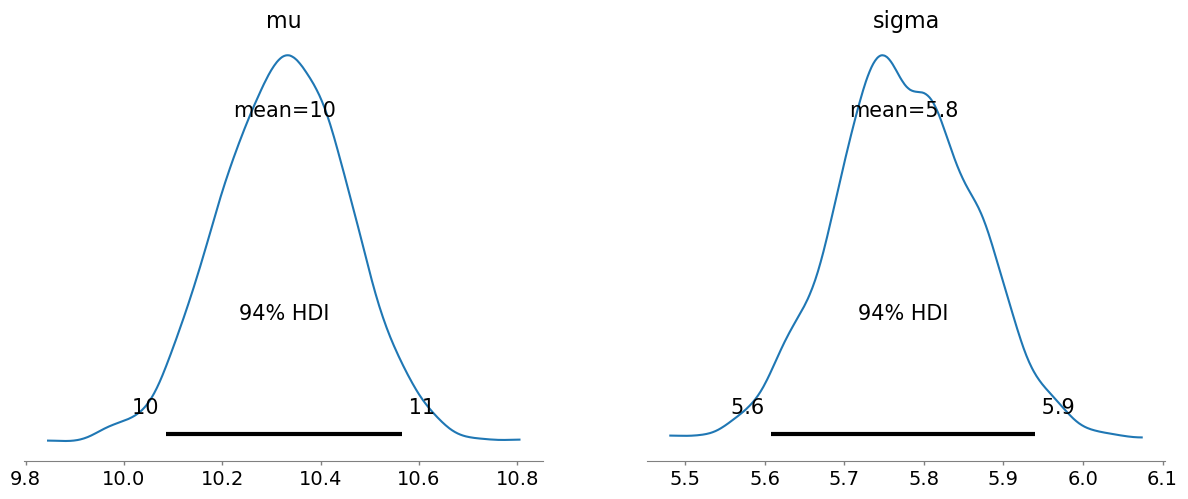

In [12]:
# Your data
dates = np.random.randint(1, 21, size=2000)

# Model
with pm.Model() as model:
    # Priors
    mu = pm.Normal("mu", mu=10, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=5)

    # Likelihood
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=dates)

    # Inference
    trace = pm.sample(2000, return_inferencedata=True, cores=2)

# Summarize results
print(az.summary(trace, hdi_prob=0.95))

# Plot posterior distributions
az.plot_posterior(trace)

In [49]:
import xarray as xr
import numpy as np

# Create a 10x10 array filled with the datetime 2000-01-05
lat = np.arange(10)
lon = np.arange(10)
date = np.datetime64("2000-01-05")

data = np.full((10, 10), date)

# Create the xarray DataArray
data_array = xr.DataArray(
    data, coords={"latitude": lat, "longitude": lon}, dims=["latitude", "longitude"]
)

# Calculate the timedelta in days from 2000-01-01
start_date = np.datetime64("2000-01-01")
timedelta_days = (data_array - start_date).astype("timedelta64[D]").astype(int)

print("Original DataArray:")
print(data_array)
print("\nTimedelta in days from 2000-01-01:")
print(timedelta_days)


Original DataArray:
<xarray.DataArray (latitude: 10, longitude: 10)> Size: 800B
array([['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000'],
       ['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000'],
       ['2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.000000000', '2000-01-05T00:00:00.000000000',
        '2000-01-05T00:00:00.0

/tmp/ipykernel_91163/3599759843.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_array = xr.DataArray(
/tmp/ipykernel_91163/3599759843.py:18: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision

AttributeError: 'DataArray' object has no attribute 'datetime'

In [50]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da


# Function to calculate the date when cumulative sum reaches the threshold
def myfunc(degree_days, start_time_values):
    #select 
    return degree_days["time"].values[0]


# Vectorize the function

# Input data
time = pd.date_range("2000-01-01", periods=50, freq="D").to_numpy(
    dtype="datetime64[ns]"
)
lat = np.linspace(-90, 90, 10)
lon = np.linspace(-180, 180, 10)
degree_days = xr.DataArray(
    da.random.random((10, 10, 50)),
    coords=[lat, lon, time],
    dims=["lat", "lon", "time"],
)
start_dates = xr.DataArray(
    np.random.choice(time[:5], size=(10, 10)), coords=[lat, lon], dims=["lat", "lon"]
)
start_indices = np.array(
    [np.where(degree_days.time.values == d)[0][0] for d in start_dates.values.flatten()]
).reshape(start_dates.shape)
threshold = 15

degree_days.load()
# Apply the function using xr.apply_ufunc
result_raw = xr.apply_ufunc(
    myfunc,
    degree_days,
    degree_days.time.values.astype("datetime64[ns]"),
    input_core_dims=[["time"], ["time"]],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.datetime64],
)

# Compute the result
result = result_raw.compute()
# print(result)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [44]:
df = degree_days.to_dask_dataframe()

In [49]:
df["time"].values.compute()

array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', ...,
       '2000-02-17T00:00:00.000000000', '2000-02-18T00:00:00.000000000',
       '2000-02-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [16]:
result

<xarray.DataArray 'random_sample-0deae3d2b57b3970034734ef19a7c8c2' (lat: 10,
                                                                    lon: 10)> Size: 800B
array([[9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17],
       [9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17, 9.467712e+17, 9.467712e+17,
        9.467712e+17, 9.467712e+17]])
Coordinates:
  * lat      (lat) float64 80B -90.0 -70.0 -50.0 -30.0 ... 30.0 50.0 70.0 90.0
  * lon      (lon) float64 80B -180.0 -140.0 -100.0 -60.0 ... 100.0 140.0 180.0

In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da


# Function to return the start time value
def day_cumsum_reaches_threshold_linear(
    degree_days, start_index, start_time_values, threshold
):
    return start_time_values[1]


# Vectorize the function
vday_cumsum_reaches_threshold_linear = np.vectorize(day_cumsum_reaches_threshold_linear)

# Input data
time = pd.date_range("2000-01-01", periods=50, freq="D").to_numpy(
    dtype="datetime64[ns]"
)
lat = np.linspace(-90, 90, 10)
lon = np.linspace(-180, 180, 10)
degree_days = xr.DataArray(
    da.random.random((10, 10, 50), chunks=(10, 10, -1)),
    coords=[lat, lon, time],
    dims=["lat", "lon", "time"],
)
start_dates = xr.DataArray(
    np.random.choice(time[:5], size=(10, 10)), coords=[lat, lon], dims=["lat", "lon"]
)
start_indices = np.array(
    [np.where(degree_days.time.values == d)[0][0] for d in start_dates.values.flatten()]
).reshape(start_dates.shape)
threshold = 15

# Apply the function using xr.apply_ufunc
result_raw = xr.apply_ufunc(
    day_cumsum_reaches_threshold_linear,
    degree_days,
    start_indices,
    degree_days.time.values.astype("datetime64[ns]"),
    threshold,
    input_core_dims=[["time"], [], ["time"], []],
    output_core_dims=[[]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.datetime64],
)

# Compute the result
result = result_raw.compute()
print(result)

ValueError: Dimension `'__loopdim1__'` with different lengths in arrays

In [52]:
start_date = np.datetime64("2000-01-01")
target_date = np.datetime64("2000-01-05")
timedelta_days = (target_date - start_date).astype("timedelta64[D]")
timedelta_days

numpy.timedelta64(4,'D')

In [ ]:
np.timedelta64(4, "D").astype(int)

In [44]:
# select data where year is 2015
ffoo = data["f3_maturation_dates"].sel(year=2012)
timedelta_days = (foo - np.datetime64("2012-01-01")).astype("timedelta64").astype(int)
timedelta_days = timedelta_days / (86400 * 10**9)  # convert to int
timedelta_days = timedelta_days.astype(int)
timedelta_days

<xarray.DataArray 'f3_maturation_dates' (latitude: 12, longitude: 12)> Size: 1kB
array([[      3,       3,       3,       3,       3,       3,       3,
              3,       3,       6,       6,       6],
       [      3,       3,       3,       3,       3,       3,       3,
              3,       3,       4,       4,       3],
       [      3,       3,       3,       3,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      3,       3,       3,       3,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      1,       1,       1,       3,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      3,       3,       3,       3,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      4,       4,       4,       4,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      5,       5,       4,       4,       3,       3,       3,
              3,       3,       3,       3,       3],
       [      8,       5,       4,       4,       4,       3,       3,
              3,       3,       3,       3,       3],
       [-106751,       8,       4,       4,       4,       4,       4,
              4,       3,       3,       3,       3],
       [-106751, -106751,       8,       4,       4,       4,       4,
              4,       4,       4,       4,       3],
       [-106751, -106751,     366,       4,       4,       4,       4,
              4,       4,       4,       4,       4]])
Coordinates:
  * latitude   (latitude) float64 96B 34.29 34.25 34.21 ... 33.92 33.88 33.83
  * longitude  (longitude) float64 96B -118.5 -118.5 -118.4 ... -118.1 -118.0
    year       int64 8B 2012

In [42]:
bar = datetime.datetime(345600000000000)
bar.astype("timedelta64[D]").astype(int)

OverflowError: signed integer is greater than maximum

In [ ]:
plot_threshold_reached_dates(
    la_threshold_reached_days_2,
    export_html=True,
    output_file="la_threshold_reached_days_2.html",
)